### Desafío Data Science - Juliana Plácido

#### Notebook IIII
Optimización de hiperparámetros:

In [3]:
#Importación de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna
from optuna.integration import OptunaSearchCV
from optuna.exceptions import TrialPruned
from optuna.samplers import TPESampler
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances


import gc
import warnings
warnings.filterwarnings('ignore')

In [4]:
#importamos el df
df = pd.read_csv('df_modelado.csv')


In [5]:
X = df.drop(['vlo-i','fecha-i', 'atraso_15', 'flag_adelantado'], axis=1)
y = df['atraso_15']

In [6]:
from sklearn.model_selection import train_test_split
trainSize = 0.7

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                  train_size=trainSize)

In [7]:
print('Shape X:', X_train.shape)
print('Shape y:', y_train.shape)

Shape X: (47716, 15)
Shape y: (47716,)


In [8]:
print('Shape X:', X_test.shape)
print('Shape y:', y_test.shape)

Shape X: (20450, 15)
Shape y: (20450,)


### LGBM

In [12]:
%%time
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

preds_lgbm_train = model_lgbm.predict_proba(X_train)[:,1]
preds_lgbm_test = model_lgbm.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_lgbm_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_lgbm_test) ,4)


print("ROC LGBM Baseline Train: " + str(train_roc))
print("ROC LGBM Baseline Test: " + str(test_roc))

ROC LGBM Baseline Train: 0.7737
ROC LGBM Baseline Test: 0.7286
CPU times: user 2.88 s, sys: 7.81 ms, total: 2.89 s
Wall time: 3.04 s


In [13]:
model_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [14]:
#Ya corrimos el modelo base, ahora vamos a probar optimizar los hiperparámetros:


param_grid = {'max_depth': [-1, 2, 6, 10, 12],   
              'num_leaves': list(range(20,35+1)),
              'n_estimators':[100,200,500]} 

In [15]:
%%time

# Grid Search
model_lgbm2 = GridSearchCV(model_lgbm, param_grid=param_grid, cv=5)

# Train: using the previous grid and CV with fold = 5 
model_lgbm2.fit(X_train, y_train)

CPU times: user 34min 20s, sys: 32.2 s, total: 34min 52s
Wall time: 19min 58s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'max_depth': [-1, 2, 6, 10, 12],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                        30, 31, 32, 33, 34, 35]})

In [16]:
print("Best Parameters: "+str(model_lgbm2.best_params_))

Best Parameters: {'max_depth': 6, 'n_estimators': 500, 'num_leaves': 20}


In [18]:
preds_lgbm_train = model_lgbm2.predict_proba(X_train)[:,1]
preds_lgbm_test = model_lgbm2.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_lgbm_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_lgbm_test) ,4)


print("ROC LGBM Baseline Train: " + str(train_roc))
print("ROC LGBM Baseline Test: " + str(test_roc))

ROC LGBM Baseline Train: 0.8126
ROC LGBM Baseline Test: 0.7315


In [24]:
#Visualización de métricas de performance:
#Train Modelo Nuevo
fpr_train, tpr_train, _ = roc_curve(y_train, preds_lgbm_train)
roc_auc_train = auc(fpr_train, tpr_train)

#Test Modelo Nuevo
fpr_test, tpr_test, _ = roc_curve(y_test, preds_lgbm_test)
roc_auc_test = auc(fpr_test, tpr_test)

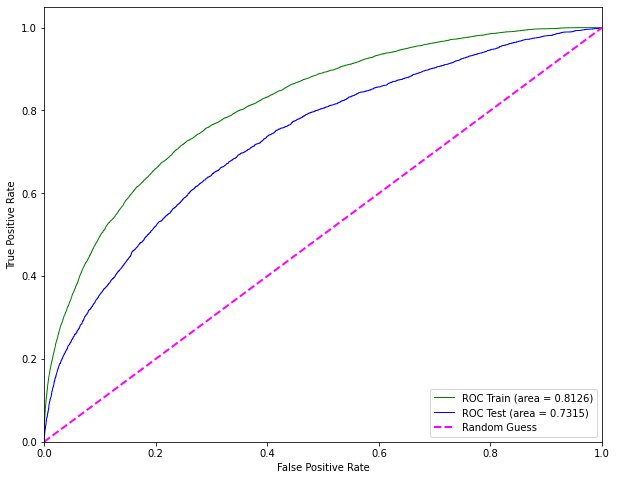

In [25]:
plt.figure(figsize=(10,8))

plt.plot(fpr_train, tpr_train, 
         color = 'green', 
         label = 'ROC Train (area = {:.4f})'.format(roc_auc_train), 
         lw = 1)
plt.plot(fpr_test, tpr_test, 
         color = 'blue', 
         label = 'ROC Test (area = {:.4f})'.format(roc_auc_test), 
         lw = 1)
plt.plot([0, 1], [0, 1], 
         color = 'magenta', 
         label = 'Random Guess', 
         lw = 2, 
         linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "lower right")

plt.show()

In [57]:
# Calculo threshold

def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])


In [28]:
# Threshold a utilizar es train
threshold_train = Find_Optimal_Cutoff(y_train, preds_lgbm_train)

threshold_test = Find_Optimal_Cutoff(y_test, preds_lgbm_test)

print("Threshold Train :", threshold_train)
print("Threshold Test :", threshold_test)

Threshold Train : [0.19202273617308685]
Threshold Test : [0.17805634688468952]


In [29]:
predicted = []
for x in preds_lgbm_test:
    if x >= threshold_train[0]:
        predicted.append(1)
    else:
        predicted.append(0)

# actual values
actual = list(y_test)
# predicted values
predicted

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Matriz de confusion : \n',matrix)

# outcome values order in sklearn
tn, fp, fn, tp = confusion_matrix(actual,predicted,labels=[0,1]).reshape(-1)
print('Valores : \n','TN: ',tn, '\n','FN: ',fn,'\n','FP: ',fp,'\n', 'TP: ',tp)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix)

Matriz de confusion : 
 [[11757  4855]
 [ 1393  2445]]
Valores : 
 TN:  11757 
 FN:  1393 
 FP:  4855 
 TP:  2445
Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.71      0.79     16612
           1       0.33      0.64      0.44      3838

    accuracy                           0.69     20450
   macro avg       0.61      0.67      0.61     20450
weighted avg       0.79      0.69      0.72     20450



### XGBoost

In [51]:
%%time
model_xgboost = XGBClassifier(random_state=42)
model_xgboost.fit(X_train, y_train)

preds_xgb_train = model_xgboost.predict_proba(X_train)[:,1]
preds_xgb_test = model_xgboost.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_xgb_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_xgb_test) ,4)

print("ROC XGBoost Baseline Train: " + str(train_roc))
print("ROC XGBoost Baseline Test: " + str(test_roc))

ROC XGBoost Baseline Train: 0.8273
ROC XGBoost Baseline Test: 0.7321
CPU times: user 11.2 s, sys: 947 ms, total: 12.2 s
Wall time: 1.59 s


In [52]:
model_xgboost.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [41]:
#Tratamos de optimizar estos hiperparámetros:
def default_objective(trial):

    param = {
                "random_state"     : 42,  
                "num_leaves"       : trial.suggest_int("num_leaves", 2, 12),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 12),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "n_estimators"     : trial.suggest_int("n_estimators", 100, 600), 
                "learning_rate"   : trial.suggest_float('learning_rate', 0.01, 0.3),
                "reg_alpha": trial.suggest_loguniform('reg_alpha', 1e-1, 1e1),
                "reg_lambda": trial.suggest_loguniform('reg_lambda', 1e-1, 1e1),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
                ##"subsample"        : 1
            }

    
    
    model_pipeline = XGBClassifier(**param, silent=True,
                                            ##monotone_constraints=monotone_constraints,
                                            n_jobs=6)


    m = model_pipeline.fit(X_train, y_train)
    
    preds           = m.predict_proba(X_test)[:, 1]
    roc_score       = roc_auc_score(y_test, preds)
    preds_train     = m.predict_proba(X_train)[:, 1]
    roc_score_train = roc_auc_score(y_train, preds_train)
    trial.set_user_attr('overfit', roc_score_train - roc_score)
    if roc_score_train - roc_score < 0.045:
        return roc_score
    raise TrialPruned()

    if objective  == None:
        objective = default_objective
    else:
        objective = objective
    gc.collect()

In [42]:
def do_optuna_tuning(minimize_overfit = True):
    
    study = optuna.create_study(direction = "maximize")
    study.optimize(default_objective, n_trials = 100, n_jobs=6)

    if minimize_overfit:
        trial      = study.best_trial
        best_trial = sorted([t for t in study.trials if t.value != None and t.value >= trial.value - 0.0005],
                            key = lambda a: a.user_attrs['overfit'])[0]
    else:
        best_trial = study.best_trial
    params         = best_trial.params
    params.update({'random_state': 42}) 
    return study,trial,best_trial

In [43]:
gc.collect()
study,trial,best_trial=do_optuna_tuning()

[I 2023-02-15 15:17:15,967] A new study created in memory with name: no-name-5f37c595-3c14-4e53-9fcb-39f89411b14d
[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves", "silent" } are not used.

[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves", "silent" } are not used.

[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves", "silent" } are not used.

[15:17:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_sa

In [44]:
selected_trial = best_trial
selected_trial

FrozenTrial(number=42, state=TrialState.COMPLETE, values=[0.7263960286874875], datetime_start=datetime.datetime(2023, 2, 15, 15, 21, 46, 277616), datetime_complete=datetime.datetime(2023, 2, 15, 15, 22, 1, 890901), params={'num_leaves': 10, 'min_samples_split': 5, 'max_depth': 4, 'n_estimators': 212, 'learning_rate': 0.20301523697242135, 'reg_alpha': 0.6621121737222712, 'reg_lambda': 0.45890547125306674, 'feature_fraction': 0.9, 'random_state': 42}, user_attrs={'overfit': 0.044194259872910036}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=12, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=12, log=False, low=2, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=600, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': Floa

In [45]:
selected_params = {k:v for (k,v) in best_trial.params.items()}
selected_params

{'num_leaves': 10,
 'min_samples_split': 5,
 'max_depth': 4,
 'n_estimators': 212,
 'learning_rate': 0.20301523697242135,
 'reg_alpha': 0.6621121737222712,
 'reg_lambda': 0.45890547125306674,
 'feature_fraction': 0.9,
 'random_state': 42}

In [47]:
%%time 
# Corrida ganadora - Entrenamos el modelo con el dataframe de Train y los parámetros ganadores:
gc.collect()
params =  {'num_leaves': [10],
             'min_samples_split': [5],
             'max_depth': [4],
             'n_estimators': [212],
             'learning_rate': [0.20301523697242135],
             'reg_alpha': [0.6621121737222712],
             'reg_lambda': [0.8171377954100283],
             'feature_fraction': [0.45890547125306674],
             'random_state': [42]}

grid_search = GridSearchCV(estimator=model_xgboost, param_grid=params, 
                           cv=3, scoring='roc_auc', n_jobs=5)

grid_search.fit(X_train,y_train)

[15:28:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "min_samples_split", "num_leaves" } are not used.

CPU times: user 14.8 s, sys: 1.25 s, total: 16.1 s
Wall time: 6.59 s


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=5,
             param_

In [48]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 All results:
{'mean_fit_time': array([3.58357604]), 'std_fit_time': array([0.01381328]), 'mean_score_time': array([0.0434312]), 'std_score_time': array([0.00049669]), 'param_feature_fraction': masked_array(data=[0.45890547125306674],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.20301523697242135],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[4],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[5],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[212],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_num_leaves': masked_array(data=[10],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_random_state': masked_array(data=[42],
         

In [49]:
xgb_model = XGBClassifier(**selected_params, 
                            silent=True, metric = 'auc')
xgb_model.fit(X_train, y_train)

[15:28:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "feature_fraction", "metric", "min_samples_split", "num_leaves", "silent" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_fraction=0.9,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.20301523697242135, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None, metric='auc',
              min_child_weight=None, min_samples_split=5, missing=nan,
              monotone_constraints=None, n_estimators=212, n_jobs=None, ...)

In [53]:
%%time

preds_xgb_train = xgb_model.predict_proba(X_train)[:,1]
preds_xgb_test = xgb_model.predict_proba(X_test)[:,1]

train_roc = round(roc_auc_score(y_train, preds_xgb_train) ,4) 
test_roc = round(roc_auc_score(y_test, preds_xgb_test) ,4)

print("ROC XGBoost Opt Train: " + str(train_roc))
print("ROC XGBoost Opt Test: " + str(test_roc))

ROC XGBoost Opt Train: 0.7706
ROC XGBoost Opt Test: 0.7264
CPU times: user 479 ms, sys: 46.4 ms, total: 525 ms
Wall time: 91.4 ms


In [54]:
#Visualización de métricas de performance:
#Train Modelo Nuevo
fpr_train, tpr_train, _ = roc_curve(y_train, preds_xgb_train)
roc_auc_train = auc(fpr_train, tpr_train)

#Test Modelo Nuevo
fpr_test, tpr_test, _ = roc_curve(y_test, preds_xgb_test)
roc_auc_test = auc(fpr_test, tpr_test)

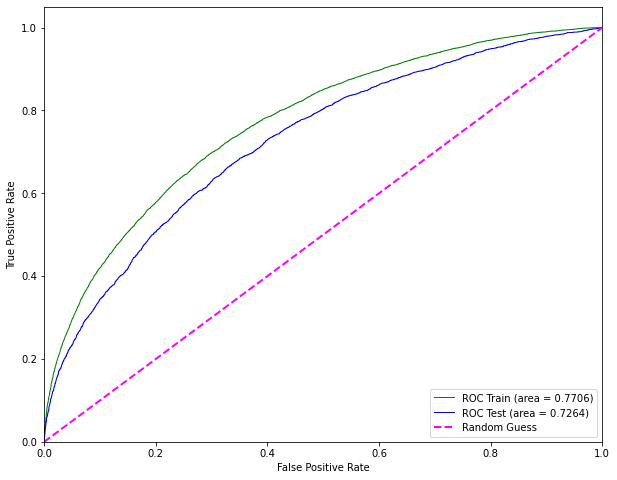

In [55]:
plt.figure(figsize=(10,8))

plt.plot(fpr_train, tpr_train, 
         color = 'green', 
         label = 'ROC Train (area = {:.4f})'.format(roc_auc_train), 
         lw = 1)
plt.plot(fpr_test, tpr_test, 
         color = 'blue', 
         label = 'ROC Test (area = {:.4f})'.format(roc_auc_test), 
         lw = 1)
plt.plot([0, 1], [0, 1], 
         color = 'magenta', 
         label = 'Random Guess', 
         lw = 2, 
         linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "lower right")

plt.show()

In [58]:
# Threshold a utilizar es train
threshold_train = Find_Optimal_Cutoff(y_train, preds_xgb_train)

threshold_test = Find_Optimal_Cutoff(y_test, preds_xgb_test)

print("Threshold Train :", threshold_train)
print("Threshold Test :", threshold_test)

Threshold Train : [0.18748228251934052]
Threshold Test : [0.182092547416687]


In [60]:
predicted = []
for x in preds_xgb_test:
    if x >= threshold_train[0]:
        predicted.append(1)
    else:
        predicted.append(0)

# actual values
actual = list(y_test)
# predicted values
predicted

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[0,1])
print('Matriz de confusion : \n',matrix)

# outcome values order in sklearn
tn, fp, fn, tp = confusion_matrix(actual,predicted,labels=[0,1]).reshape(-1)
print('Valores : \n','TN: ',tn, '\n','FN: ',fn,'\n','FP: ',fp,'\n', 'TP: ',tp)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[0,1])
print('Classification report : \n',matrix)

Matriz de confusion : 
 [[11341  5271]
 [ 1353  2485]]
Valores : 
 TN:  11341 
 FN:  1353 
 FP:  5271 
 TP:  2485
Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.68      0.77     16612
           1       0.32      0.65      0.43      3838

    accuracy                           0.68     20450
   macro avg       0.61      0.67      0.60     20450
weighted avg       0.79      0.68      0.71     20450



In [62]:
feat_imp_xgb = pd.DataFrame()
feat_imp_xgb['Variable'] = X_train.columns
feat_imp_xgb['importance'] = xgb_model.feature_importances_
feat_imp_xgb = feat_imp_xgb.sort_values(by='importance', ascending=False)
feat_imp_xgb

,Variable,importance
4,tipo_vuelo,0.330058
5,periodo_dia,0.087492
1,mes,0.078245
14,cod_aerolinea,0.069174
13,cod_destino,0.064680
8,Lunes,0.055931
2,temporada_alta,0.048162
12,Viernes,0.047001
7,Jueves,0.041353
0,dia,0.040863


Si comparamos los modelos:

LGBM Original:
ROC LGBM Baseline Train: 0.7737
ROC LGBM Baseline Test: 0.7286

LGBM Optimizado:
ROC LGBM Opt Train: 0.8126
ROC LGBM Opt Test: 0.7315

XGB Original:
ROC XGBoost Baseline Train: 0.8273
ROC XGBoost Baseline Test: 0.7321


XGB Optimizado:
ROC XGBoost Opt Train: 0.7706
ROC XGBoost Opt Test: 0.7264

Vemos que todos performan de manera muy similar. 

Un dato importante que podríamos destacar es que a medida en que optimizamos XGBoost, perdemos poder predictivo en test pero lo positivo es que la brecha entre train y test se achica, lo que implicaría que nuestro modelo overfittea menos. 

Por otro lado, si vemos LGBM, al optimizarlo la brecha entre train y test crece, pero tambien suben los rendimientos. 

Sin embargo, todos los resultados son muy similares y así mismo, al ser modelos de por si muy optimizados, la optimización extra no aporta poder predictivo ni cambios significativos en nuestros modelos.


Para mejorar performance, podríamos incluir nuevas variables, por ejemplo cantidad de empleados de la aerolínea (si la aerolinea tiene poco personal, hay mas posibilidades de que se atrase el vuelo por falta de tripulacion), información sobre los feriados calendario, personal del aeropuerto, etc.
Otra opción que creemos interesante probar, es sumar otro año más al dataset (ejemplo 2018), ya que como no son tantos registros, no nos llevaría tanto tiempo de procesamiento.

Notamos que el tipo de vuelo, periodo del día (tarde, noche o mañana) y el mes del año, son variables muy importantes al momento de predecir.

Sería bueno poder validar estos resultados con una base OOT (out of time), la cual no quisimos seleccionar de nuestra base inicial, debido a que queríamos realizar el entrenamiento con el año completo para que el modelo pueda captar la estacionalidad.
